---
# **Predicción sobre la demanda en el servicio Bicing**
---


## **Introducción**

El objetivo de este notebook realizado por **Fernando Guirao** y **Nicolás Llorens** es exponer el tema a tratar en el proyecto de la asignatura de APA (Q1 23-24). En este proyecto debe escogerse un conjunto de datos sobre el que reolver un problema de regresión o un problema de clasificación. A continuación explicaremos el problema que queremos resolver, qué datos hemos obtenido y cómo los hemos obtenido, además de un análisis preliminar de los mismos.

## **¿Qué es Bicing?**

**Bicing** es un servicio de alquiler de bicicletas promovido por el Ayuntamiento de Barcelona. Dispone de bicicletas mecánicas y eléctricas que pueden ser recogidas y dejadas en las diferentes estaciones que hay repartidas por la ciudad.

## **Motivación**


Muchos estudiantes del Campus Nord usan este servicio para ir y volver de la universidad, pero la alta demanda hace que las estaciones aledañas a menudo queden vacías obligando a muchos a escoger transportes alternativos.

Naturalmente el servicio cuenta con remolcadores que reponen bicicletas en las estaciones que se quedan vacías a ciertas horas del día. Pero a veces, quizás esto no es suficiente o no esta bien organizado.

Nuestra idea inicial es realizar predicciones sobre la demanda por cada estación en una determinada hora del día. Esta información puede resultar muy valiosa para que , de forma preventiva, se puedan reponer bicicletas en la estación ante horas donde se espera una alta demanda.

Concretamente trabajaremos sobre los datos de la estación numero 422 que se encuentra en la **Calle Jordi Girona, 29**, ya que es la estación que se encuentra justo debajo del campus. No obstante la idea es que este modelo pueda aplicarse a cuqluier estación, siempre y cuando sea entrenado con los datos de esta.

## **Obtención de los datos, filtrados y modificaciones**

Los datos sobre los que trabajaremos se encuentran en el catálogo de datasets de **Open Data BCN**. El [dataset original](https://opendata-ajuntament.barcelona.cat/data/ca/dataset/estat-estacions-bicing) recoge información sobre el estado de **todas** las estaciones a cada momento (cada pocos minutos).

Debido al gran tamaño de estos datos (dado que existen más de 500 estaciones), estos se dividen en varios archivos (uno por mes). Estas son las columnas que contiene cada archivo:

- **`last_updated`**: Timestamp del archivo.
- **`ttl`**: Tiempo de vida de la respuesta.
- **`data`**: Contenedor de arrays de información de estaciones.
- **`station`**: Array de datos de cada estación.
- **`station_id`**: Identificador de la estación.
- **`num_bikes_available`**: Número de bicicletas disponibles.
- **`num_bikes_available_types`**: Array de tipos de bicicletas disponibles.
- **`mechanical`**: Número de bicicletas mecánicas disponibles.
- **`ebike`**: Número de bicicletas eléctricas disponibles.
- **`num_docks_available`**: Número de anclajes disponibles.
- **`is_installed`**: Si la estación está correctamente instalada (0-NO,1-SÍ).
- **`is_renting`**: Si la estación está proporcionando bicicletas correctamente.
- **`is_returning`**: Si la estación está anclando bicicletas correctamente.
- **`last_reported`**: Timestamp de la información de la estación.
- **`is_charging_station`**: Si la estación tiene capacidad de carga de bicicletas eléctricas.
- **status**: Estado de la estación (IN_SERVICE=En servicio, CLOSED=Cerrada)​​.

De este dataset, extraemos información del estado de la estacion y no tanto del movimiento de esta al tener logs del status de la estacion de entre 5-10 minutos, lo que puede no capturar todos los movimientos de esta. Por lo tanto de cara al dataset final nos sirve para calcular la variable **`demand_satisifed`**.

Despues de hablar con BSM (empres publica responsable de la movilidad de Barcelona) conseguimos los registros (logs) de todos los viajes de todas las estaciones de los años 2021,2022 y 2023 (hasta noviembre).

Estos logs tienen estas columnas:
- **`Trip Id`**: Id del viaje.
- **`Start Time`**: Momento del inicio del viaje en formato: AAAA-MM-DD HH:MM:SS.
- **`End Time`**: Momento del final del viaje en formato: AAAA-MM-DD HH:MM:SS.
- **`Start Station Id`**: Id de la estacion de comienzo.
- **`End Station Id`**: Id de la estacion de llegada.
- **`Bike Model`**: Tipo de bici puede ser  **ELECTRICA** o **MECANICA**.

De estos logs, hemos hecho un filtrado de solo los viajes que empiezan o acaban en la estacion 422, marcando si empiezan en esta como una salida y si llegan a esta como una llegada. Ademas, hemos agrupado todos estos viajes en horas, por lo que obtenemos un dataset con las columnas **`year`**,**`month`**,**`day`**,**`day_week`**,**`exits`**,**`arrivals`**, donde exits y arrivals son el total de salidas y llegadas en una fecha y hora determinada.


Queda lo de OpenMeteo


## **Visualización de los datos**

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import scatter_matrix

data = pd.read_csv('dataset_generation/dataset.csv')

data.sample(5)

,hour,day,month,year,week_day,exits,arrivals,temperature_2m,apparent_temperature,precipitation,rain,wind_speed_10m,demand_satisfied
1906,10,21,3,2021,Sunday,0,1,12.590000,9.333202,0.0,0.0,7.754637,True
18516,12,11,2,2023,Saturday,3,0,12.090000,10.201457,0.0,0.0,4.198285,True
3273,9,17,5,2021,Monday,1,3,18.039999,15.072102,0.1,0.1,24.365910,True
23598,6,11,9,2023,Monday,0,0,18.490000,20.709173,0.0,0.0,4.896530,False
17705,17,8,1,2023,Sunday,1,5,12.940001,11.668676,0.0,0.0,10.105681,True


In [61]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
hour,25536.0,NaN,NaN,NaN,11.5,6.922322,0.0,5.75,11.5,17.25,23.0
day,25536.0,NaN,NaN,NaN,15.712406,8.791936,1.0,8.0,16.0,23.0,31.0
month,25536.0,NaN,NaN,NaN,6.366541,3.3669,1.0,3.0,6.0,9.0,12.0
year,25536.0,NaN,NaN,NaN,2021.970865,0.81002,2021.0,2021.0,2022.0,2023.0,2023.0
week_day,25536,7,Friday,3648,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exits,25536.0,NaN,NaN,NaN,2.257206,3.67823,0.0,0.0,1.0,3.0,42.0
arrivals,25536.0,NaN,NaN,NaN,2.334469,3.495177,0.0,0.0,1.0,3.0,28.0
temperature_2m,25536.0,NaN,NaN,NaN,17.000444,7.073565,-1.61,11.59,17.039999,22.539999,36.79
apparent_temperature,25536.0,NaN,NaN,NaN,16.598101,8.96968,-6.082399,9.538431,16.284276,24.112098,40.271996
precipitation,25536.0,NaN,NaN,NaN,0.063878,0.444218,0.0,0.0,0.0,0.0,18.0


Renombramos variables para simplificar


In [62]:
data.rename(columns={'temperature_2m': 'temperature', 'wind_speed_10m': 'windspeed'}, inplace=True)


Convertimos demand satisfied y week_day a variable numerica 

In [63]:
data['demand_satisfied'] = data['demand_satisfied'].fillna(0).astype(int)

data['week_day'] = data['week_day'].map({'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7})



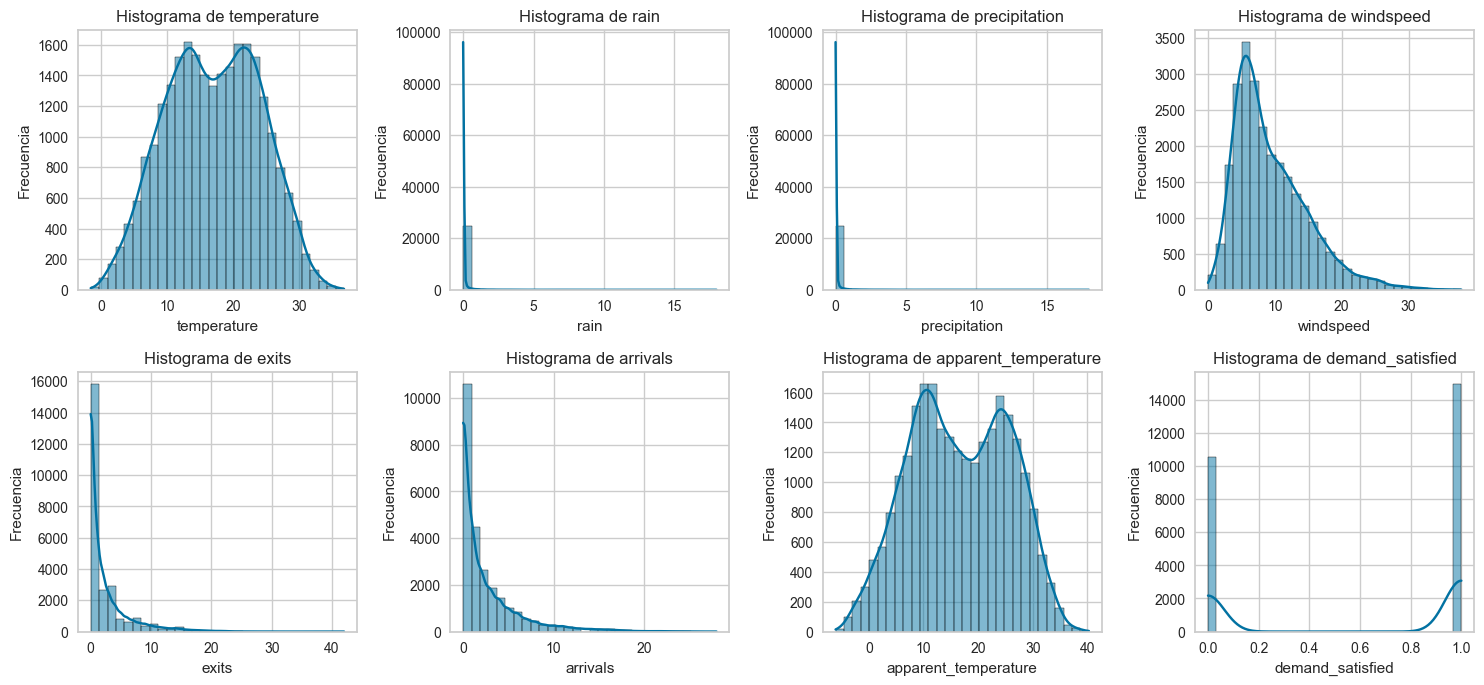

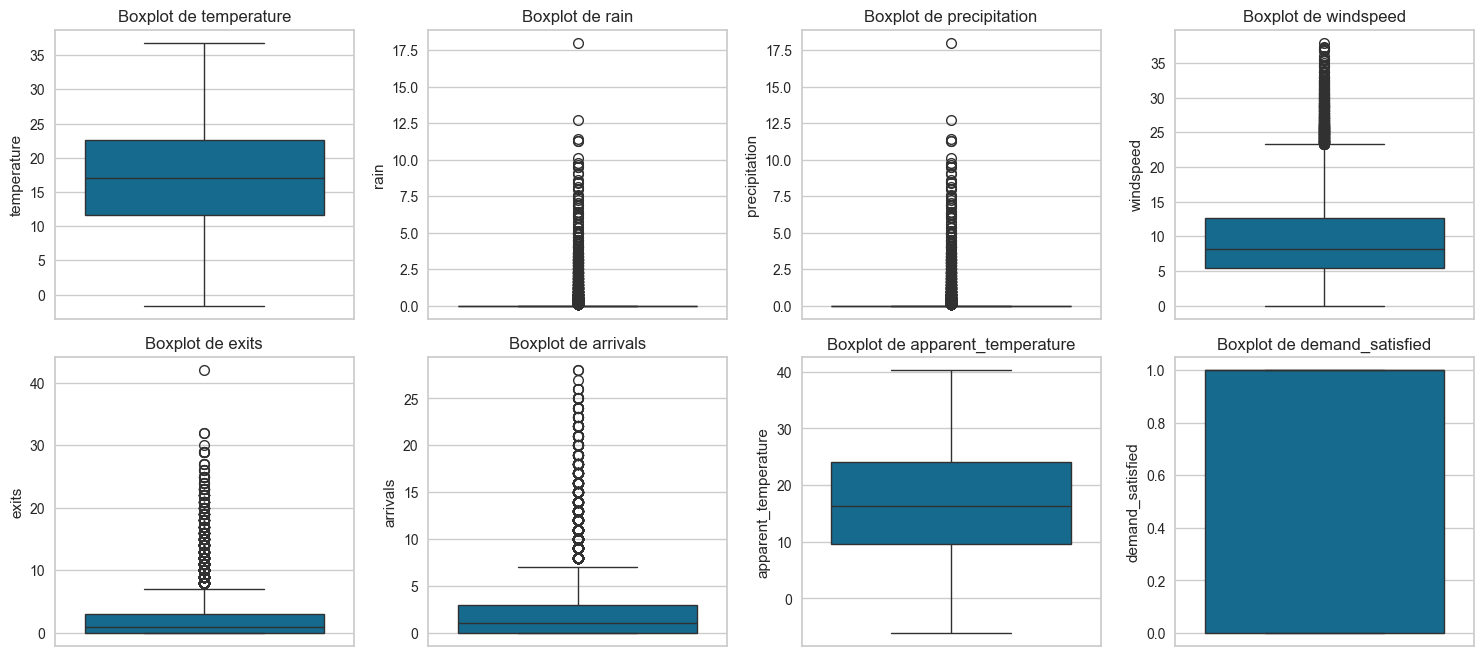

In [64]:
# Lista de variables numéricas
numeric_vars = ["temperature", "rain", "precipitation", "windspeed", "exits", "arrivals", "apparent_temperature",  "demand_satisfied"]

# Visualización de histogramas para las variables numéricas
plt.figure(figsize=(15, 10))

for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data[var], kde=True, bins=30)
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Visualización de boxplots para las variables numéricas
plt.figure(figsize=(15, 10))

for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(y=data[var])
    plt.title(f'Boxplot de {var}')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

Como vemos rain y precipitation nos da la misma informacion por lo que nos quedaremos con precipitation

In [65]:
data.drop("rain", axis=1, inplace=True)


Diferencia de entere exits si eliminamos las filas en las que la demanda no se ha cumplido

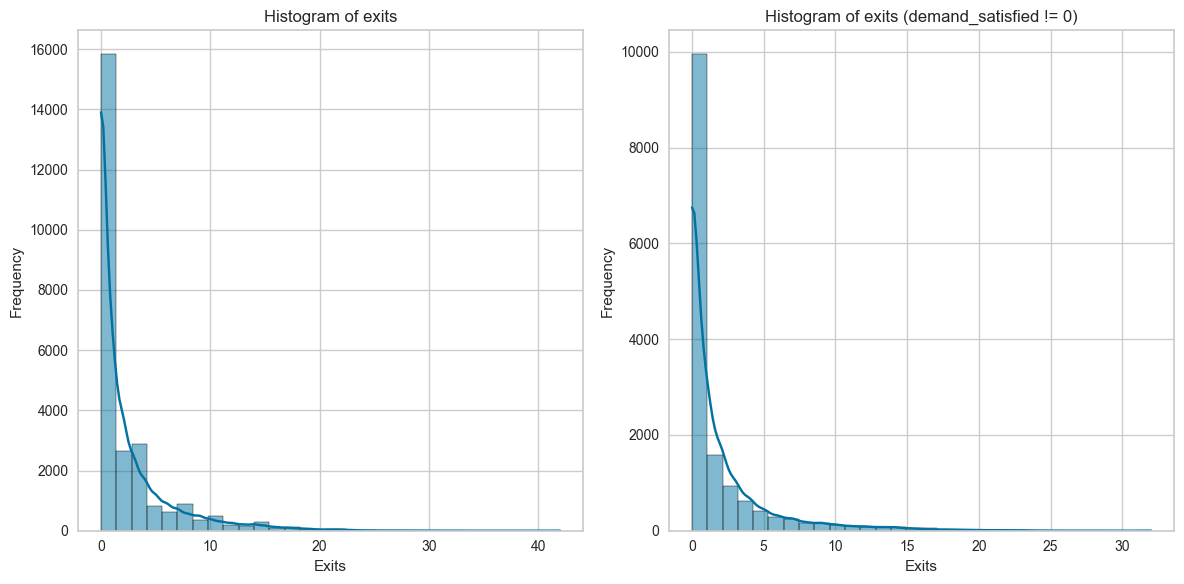

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram of exits
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['exits'], kde=True, bins=30)
plt.title('Histogram of exits')
plt.xlabel('Exits')
plt.ylabel('Frequency')

# Plot histogram of exits without rows where demand_satisfied = 0
plt.subplot(1, 2, 2)
sns.histplot(data[data['demand_satisfied'] != 0]['exits'], kde=True, bins=30)
plt.title('Histogram of exits (demand_satisfied != 0)')
plt.xlabel('Exits')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Relacion de exits vs variables meteorologicas

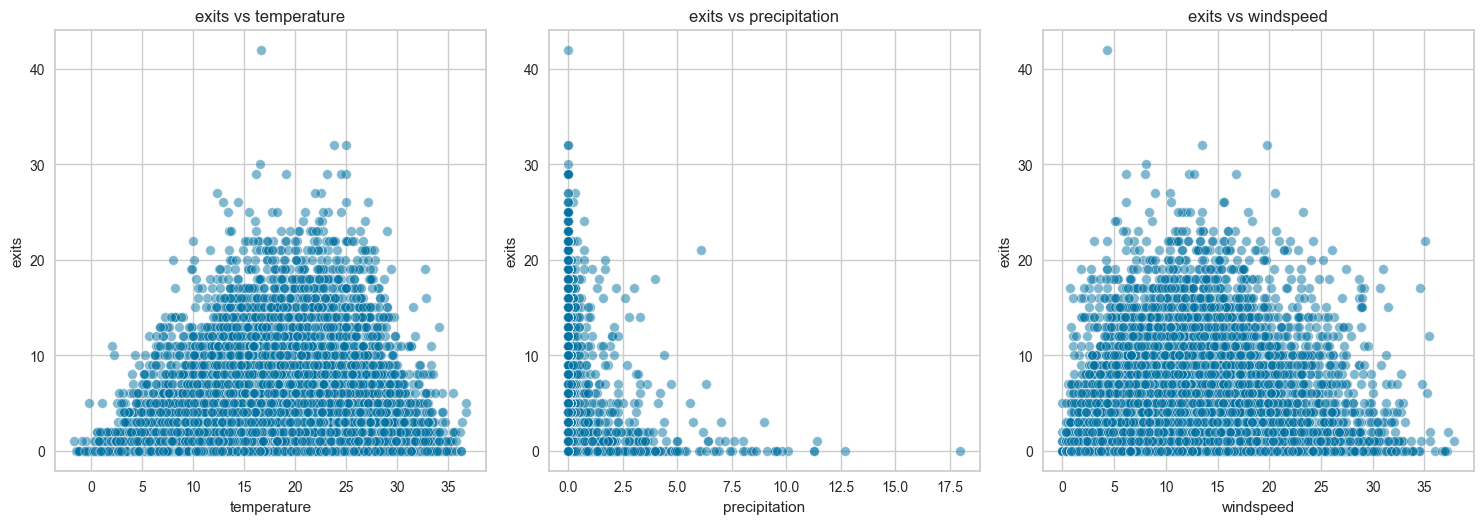

In [67]:
# Variables numéricas y categóricas seleccionadas
numeric_vars_selected = ["temperature", "precipitation", "windspeed"]

# Gráficos de dispersión para variables numéricas
plt.figure(figsize=(15, 10))
for i, var in enumerate(numeric_vars_selected, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=data, x=var, y="exits", alpha=0.5)
    plt.title(f'exits vs {var}')

plt.tight_layout()
plt.show()

Se aprecian tendencias naturales:
- La mayoría de exits, se realizan cuando las temperaturas son moderadas.
- En el caso de la lluvia (precipitation), es todavía más notorio que cuando no llueve o la lluvia es mínima, se cogen la mayoría de bicicletas.
- El viento no afecta tanto, pero sí que es cierto que cuando este alcanza velocidades considerables, el número de salidas cae bastante.

Vamos ahora a comparar el número de salidas con las variables categóricas `day`, `week_day`, `day`, `month`, `hour`:

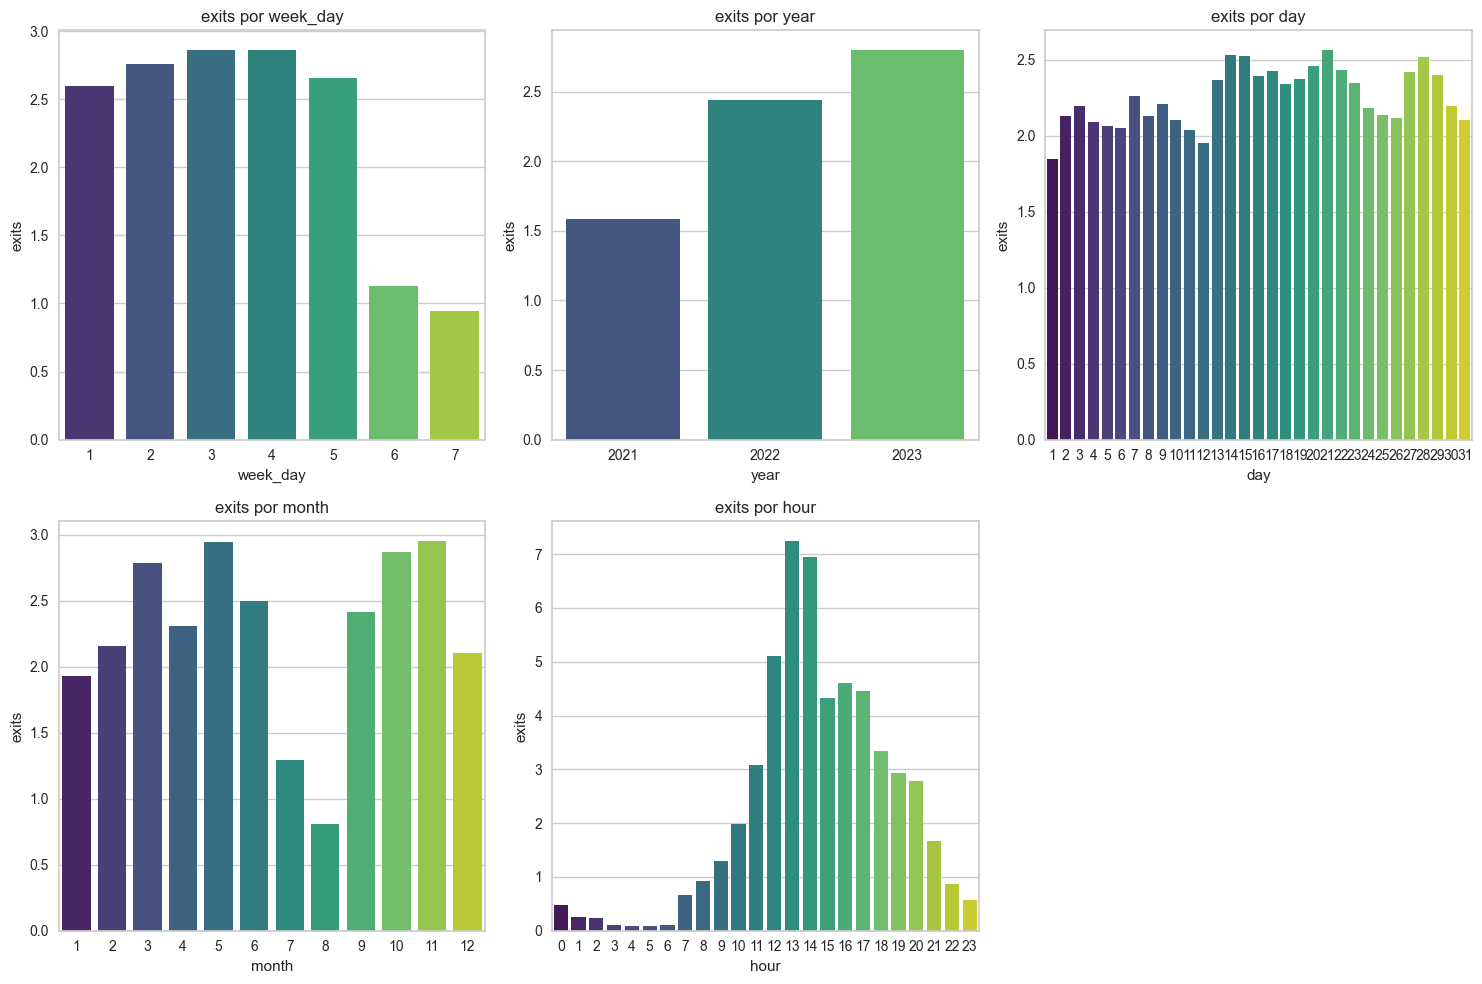

In [68]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Eliminar warnings

categorical_vars_selected = ["week_day", "year", "day", "month", "hour"]

plt.figure(figsize=(15, 10))
for i, var in enumerate(categorical_vars_selected, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=data, x=var, y="exits", errorbar=None, palette="viridis") 
    plt.title(f'exits por {var}')

plt.tight_layout()
plt.show()



Aquí de nuevo extraemos conclusiones interesantes sobre variables que tienen una clara influencia sobre la variable objetivo:
- La cantidad de bicicletas eléctricas que se cogen en días laborables duplican a las que se cogen en días festivos.
- Existe un claro descenso de la salida de bicicletas durante el fin de semana.
- No se aprecian tendencias claras según el día del mes, ya que un mismo número de día puede caer en días de la semana distintos cada mes.
- Otro claro descenso es el que se produce en los meses de verano. Además también es notorio el repunte (seguramente motivado por el inicio del buen tiempo) en mayo.
- El uso por horas parece estar normalmente distribuido, produciendose el pico justo en las horas centrales.
- Como dato interesante vemos el crecimiento de salidas segun el año, relacionado directamente con el crecimiento de usuarios de bicing.

A continuación, mostramos la matriz de correlación.

<Axes: >

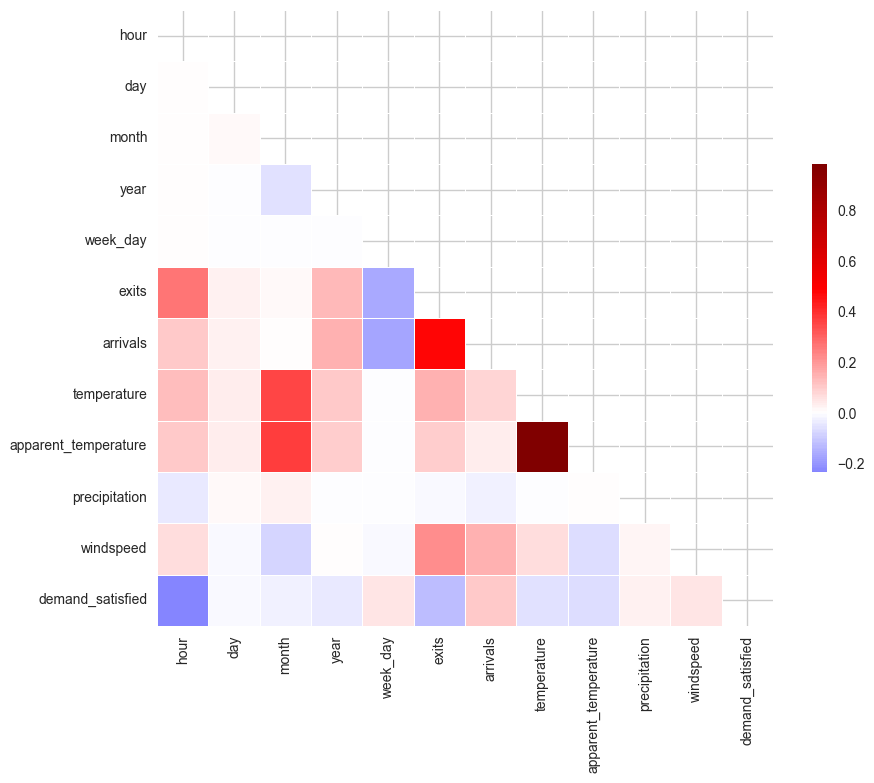

In [69]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Como podemos ver si hay ciertas correlaciones entre por ejemplo exits, con hour, year y week_day. Estas relaciones ya las habiamos visto en los graficos anteriores y reafirman nuestro analisis. Por ejemplo vemos que day y month no tienen correlacion. De la matriz de correlacion tambien podemos extraer que hay muchas relaciones no lineales en nuestro dataset, por ejemplo las relaciones entre factores temporales y exits, las cuales hemos podido ver claramente en los graficos anteriores. De esto podemos ver que probablemente modelos mas complejos que capturan este tipo de relaciones no lineales seguramente nos den buen resultado (o al menos mejor que una simple regresión lineal)

## **Resultados de referencia con un modelo de regresión lineal**

Dividiremos nuestro conjunto (en un factor de 80/20) en train y test

In [70]:
from sklearn.model_selection import train_test_split

X = data[numeric_vars_selected + categorical_vars_selected]
y = data["exits"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [74]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np

lr = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
}

grid_search = GridSearchCV(lr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Obtiene el mejor modelo
best_lr = grid_search.best_estimator_
best_params = grid_search.best_params_

r2_lr = np.mean(cross_val_score(best_lr, X_train, y_train, scoring='r2'))

best_lr.fit(X_train, y_train)


y_pred = best_lr.predict(X_test)

r2_results = pd.DataFrame(index=['lr'])

r2_results['Test R2'] = r2_score(y_test, y_pred)
r2_results['MSE'] = mean_squared_error(y_test, y_pred)
r2_results['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprime los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", best_params)

# Imprime los resultados
r2_results


Mejores hiperparámetros: {'fit_intercept': True}


,Test R2,MSE,RMSE
lr,0.172263,10.838831,3.292238


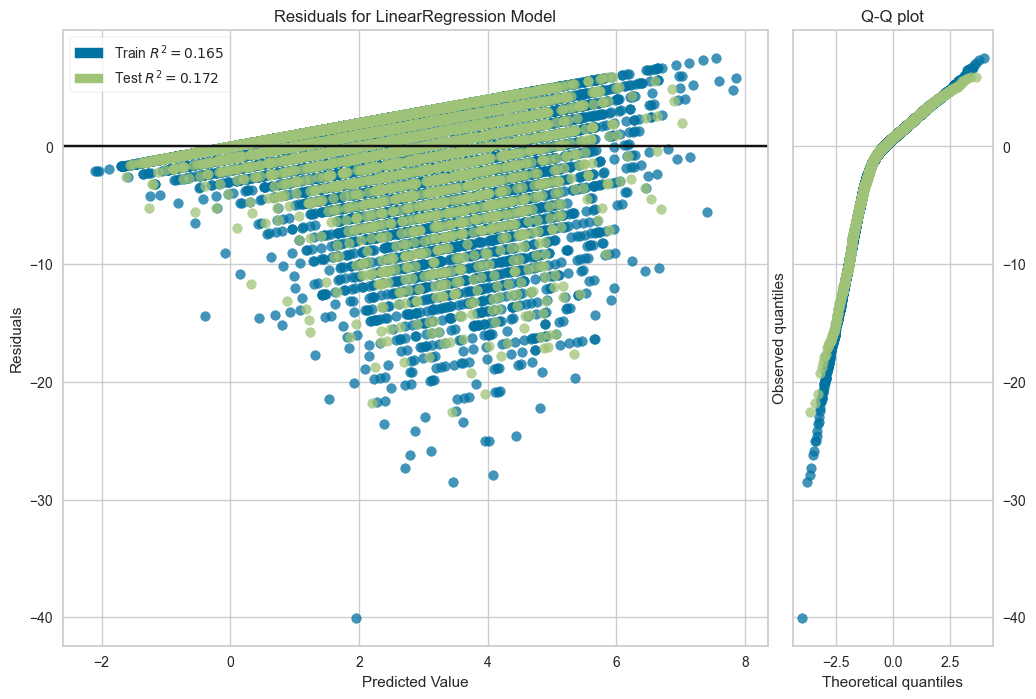

In [76]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8))
viz = residuals_plot(best_lr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False)

Como vemos con Test R2, el modelo explica entre un 16% y un 17% la variabilidad de los datos del test. 

El error cuadrático medio (MSE) para el modelo de regresión lineal en el conjunto de prueba es de 10.83

Esto sugiere que hay margen para mejorar y que modelos más sofisticados podrían ofrecer mejores predicciones.​​

Ademas, vemos que en promedio el modelo tiene un error de 3 bicicletas en la predicción. De nuevo, vemos que hay un margen de mejora que quizás podamos alcanzar con modelos más complejos.

## **Modelo K-Nearest Neighbours**

Como hemos hablado antes, es muy probable que hayan relaciones no lineales que, logicamente una regresion lineal no captura, por lo tanto puede mejorar notablmente nuestro rendimiento un modelo de este tipo


In [77]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create the K-Nearest Neighbors model
knn = KNeighborsRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and best parameters
best_knn = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the model on the test set
y_pred = best_knn.predict(X_test)

r2 = r2_score(y_test, y_pred)

# Create a new row for K-Nearest Neighbors results
r2_results.loc['knn'] = [r2, mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred))]

# Print the updated results
r2_results


,Test R2,MSE,RMSE
lr,0.172263,10.838831,3.292238
knn,0.582326,5.469243,2.338641


Conclusiones

## **Modelo SVM Cuadratica**

In [78]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['poly'],
    'degree': [2],
    'gamma': ['scale', 'auto']
}

# Create the SVM model
svm = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and best parameters
best_svm = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the model on the test set
y_pred = best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# Create a new row for SVM Poly results
r2_results.loc['SVM Poly'] = [accuracy, mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred))]

# Print the updated results
r2_results


# Print the best parameters and accuracy
print("Best parameters:", best_params)
print("Accuracy:", accuracy)


C:\Users\nicks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy: 0.466523101018011


In [79]:
r2_results

,Test R2,MSE,RMSE
lr,0.172263,10.838831,3.292238
knn,0.582326,5.469243,2.338641
SVM Poly,0.466523,18.071065,4.251008
